## "I know words..."

Trump said *"I know words, I have the best words."* So we'll be comparing his Tweeter vocabulary size with Clinton's to see if his tweets reflect this statement.

In essence, the vocabulary size is simply the number of unique words used in a text. However, we need to make some choices about the words we count. For example,

* words like "a", "the", "at", "on" don't really reflect vocabulary richness;
* singular and plural forms of a noun should only be counted once, since using "cat" and "cats" does not imply a larger vocabulary than using only "cat" or only "cats";
* similarly, a verb used in multiple tenses (e.g., "argue", "argued", "arguing") should probably only be counted once;
* proper nouns should also not be counted as part of the vocabulary, because they don't reflect vocabulary richness;
* numbers don't reflect vocabulary size either;
* hashtags and usernames used on Twitter should also be excluded from the count.

Because Twitter data tends to be very messy, we must do quite a ~~bit~~ lot of data cleaning. The steps done to clean the data are described below.

1. Trump, when tweeting from Android, mostly retweets by copy-pasting other users' tweets. Because these tweets were not originally posted by Trump, they are flagged as copy-pasted and excluded from the analysis.
2. Some tweets consist of quotes from articles published by the media. These tweets are also flagged and excluded from the analysis.
3. Words separated with an em dash, an en dash, or a forward slash are not handled by NLTK as individual words. Therefore, we will try to identify and separate these words 'manually'.
4. Exclude stopwords and other words with less than tree characters (many are abbreviations).
5. Exclude hashtags, user mentions, punctuation marks, proper nouns, ordinal and cardinal numbers (written with digits or spelled out).

---

In [2]:
import os
import re
import sys
import itertools
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import StanfordNERTagger
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [3]:
# Change the paths...
os.environ['STANFORD_MODELS'] = "/Users/gogrean/code/stanford-ner-2014-06-16/classifiers"
os.environ['CLASSPATH'] = "/Users/gogrean/code/stanford-ner-2014-06-16"
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

We use Pandas to read in the CSV files in which we saved the candidates' tweets.

In [4]:
root_dir = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

df_trump = pd.read_csv(root_dir + "data/pyladies_trumps_tweets.csv", encoding = "utf-8")
df_clinton = pd.read_csv(root_dir + "data/pyladies_clintons_tweets.csv", encoding = "utf-8")

We can look at the first few rows of the data frames...

In [ ]:
df_trump.head(3)

In [ ]:
df_clinton.head(3)

---

*EXERCISE: Write a function that identifies copy-pasted tweets. Create a new column in the dataframes to flag copy-pasted tweets.*

The next cell loads some test cases, while the following one loads a possible solution in case you need help.

In [ ]:
%load test_copy_paste_cases.py

In [ ]:
%load copy_paste_solution.py

---

*EXERCISE: Write a function that identifies tweets consisting of quoted statements from the media. Create a new column in the dataframes to flag these tweets.*

The next cell loads some test cases, while the following one loads a possible solution in case you need help.

In [ ]:
%load test_article_quote_cases.py

In [ ]:
%load article_quote_solution.py

---

Once we have the two functions above, they can be used to create `copy_paste` and `article_quote` columns in the dataframes.

In [5]:
# Here I import my own functions, but feel free to use yours instead.

from utils import is_copy_paste, is_article_quote

for i, text in enumerate(df_trump.text):
    df_trump.at[i, 'copy_paste'] = is_copy_paste(text)
    df_trump.at[i, 'article_quote'] = is_article_quote(text)

for i, text in enumerate(df_clinton.text):
    df_clinton.at[i, 'copy_paste'] = is_copy_paste(text)
    df_clinton.at[i, 'article_quote'] = is_article_quote(text)

We filter the dataframes to exclude copy-pasted tweets and tweets that consist of quoted media statements.

In [6]:
filtered_tweets_trump = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False)]
filtered_tweets_trump.reset_index(inplace=True)

filtered_tweets_clinton = df_clinton[(df_clinton.copy_paste == False) & (df_clinton.article_quote == False)]
filtered_tweets_clinton.reset_index(inplace=True)

Next we tokenize the tweets, and write the functions necessary to calculate the vocabulary size and to do the sentiment analysis. The `Tweets` class below provides most of the functionality. Please go through the code to understand what it's doing. 

A `Tweets` object is created from a dataframe containing the tweets info we downloaded in the previous notebook, e.g.

```
tweets = Tweets(filtered_tweets_clinton)
```

When instantiating `Tweets`, the text of the tweets is automatically tokenized. The tokens are afterwards used by `tag_corpus` to tag the words using the Stanford NER tagger and the default NLTK POS tagger. Using the tagged words, we exclude words that are not counted when calculating the vocabulary size (see explanation at the beginning of this notebook) using the function `filter_voc_words`. The size of the vocabulary is just the number of unique words left after filtering. the unique words are returned by `filter_unique_voc_words`, e.g.

```
tweets = Tweets(filtered_tweets_clinton)
unique_words = tweets.filter_unique_voc_words()
```

The functions `filter_voc_words` and `filter_unique_voc_words` take a `method` attribute that can be either 'stemming' (default) or 'lemmatization'. This decides how the words are processed before being added to the vocabulary.

One way to visualize the candidates' vocabulary is by creating word clouds. One of the exercises below asks you to do this using the full vocabulary. A solution is provided if you want to save time. The next exercise asks you to repeat the tasks using only superlatives and adjectives. The superlatives and adjectives are found with:

```
tweets = Tweets(filtered_tweets_clinton)
adj = tweets.find_adjectives()
sup = tweets.find_superlatives()
```

Plotting the word clouds for superlatives should require nothing more than changing the function name used in the previous word cloud exercise. The function `find_adjectives` returns a list of tuples, where each tuple has an adjective as the first item and the number of times the adjective appears in the tweets as the second item. The tuples are sorted by adjective frequency. Plotting the adjective word clouds requires converting this list of tuples into a string. 

In [96]:
P_MARKS = ["!", ".", "?", ";", ":", "?!", ")", "(", "'", 
           '"', ",", "-", "...", "…", "``", "`", "’", "“", 
           "#", "&", "@", "—", "–", "”", "‘"]
# Clinton signs her tweets with her name, so we'll exclude her name
# from the list of tokens. It should be automatically excluded since 
# we exclude proper nouns, but sometimes NLTK doesn't flag it.
HILLARY = ['hillary', '-hillary', '-h', "–hillary", "—hillary"]
STOPSET = stopwords.words('english') + HILLARY
FORBIDDEN = ["amp"] + P_MARKS

class Tweets(object):        
    def __init__(self, df):
        self.df = df
        self.tokens = []
        self._flagged_indices = []
        self._tweet_start_indices = [0]
        self._tweet_end_indices = []
        self.tokenize()

    def tokenize(self):
        '''Tokenize all tweets and store the tokens in a list.'''
        n_tokens = 0

        # We use regex to detect links in tweets. Links are removed from the text.
        url_regex = re.compile(r'https?:\/\/[a-zA-z0-9\/#%\.]+')

        for tweet, hashtags, mentions in zip(self.df.text, self.df.hashtags, self.df.user_mentions):
            hashtag_list, mention_list = [], []
            # If there are hashtags or usernames mentioned in the tweet, they are
            # split into a hashtags/mentions list.
            if hashtags is not np.nan:
                hashtag_list = [h for h in hashtags.lower().split(", ")]
            if mentions is not np.nan:
                mention_list = [m for m in mentions.lower().split(", ")]

            # Remove links.
            tweet = re.sub(url_regex, '', tweet)

            # Tokenize.
            tokens = word_tokenize(tweet)

            # Separate words containing em dash, en dash, or forward slash. 
            for sep in ["—", "–", "/"]:
                offset = 0
                # List of words that need splitting and their position in the list of tokens.
                split_words = [(i, word) for i, word in enumerate(tokens) if sep in word]
                for i, word in split_words:
                    i += offset
                    # One of the words on either side of the separator could be an empty
                    # string, in which case it's not saved in subwords.
                    subwords = [subword for subword in word.split(sep) if subword != '']
                    # The separated words are added to the list of tokens.
                    tokens[i:i+1] = subwords
                    # The offset is advanced such that next time we insert separated words 
                    # in the list of tokens they are inserted at the correct position.
                    #     +1 if there's a word on both sides of the separator
                    #      0 if there's a word only on one side of the separator 
                    #        (equivalent to simlpy removing the separator)
                    #     -1 if the dash/slash does not separate words
                    offset += (len(subwords) - 1)

            # Store the indices of the words that are either hashtags or user mentions. 
            this_tweet_flagged_indices = [n_tokens + i 
                                          for i, w in enumerate(tokens) 
                                          if w.lower() in hashtag_list or w.lower() in mention_list]
            self._flagged_indices += this_tweet_flagged_indices
            self._tweet_start_indices.append(len(tokens) + self._tweet_start_indices[-1]) 
            self._tweet_end_indices.append(self._tweet_start_indices[-1] - 1)
            n_tokens += len(tokens)
            # Add the tweet tokens to the complete list of tokens.
            self.tokens.extend(tokens)
        del self._tweet_start_indices[-1]
    
    def tag_corpus(self, remove_numbers=True, remove_hashtags_usernames=True):
        '''Tag parts of speech (POS) and identify proper nouns.'''
        
        # If you're curious exactly what this function does,
        # check out utils.py. I'll spare you the details here.
        from utils import remove_numbers
        
        st_tags = st.tag(self.tokens)

        # Words written in all caps are not always tagged
        # correctly. Each word written in all caps that 
        # was not identified as a proper noun is changed 
        # to title case and the tagging is done again to
        # to verify that it's indeed not a proper noun.
        modified_corpus = False
        for i, w in enumerate(st_tags):
            if w[0].isupper() and w[1] == 'O':
                self.tokens[i] = w[0].title()
                modified_corpus = True
        if modified_corpus:
            st_tags = st.tag(self.tokens)
            
        pos_tags = nltk.pos_tag(self.tokens)
        # If a word is a hashtag or a username, don't include
        # it in the list of tokens.
        if remove_hashtags_usernames is True:
            for index in reversed(self._flagged_indices):
                del st_tags[index]
                del pos_tags[index]
        
        if remove_numbers is True:
            st_tags = remove_numbers(st_tags)
            pos_tags = remove_numbers(pos_tags)
        
        return st_tags, pos_tags
    
    def filter_voc_words(self, st_tags=None, pos_tags=None, method='stemming'):
        '''Filter out words that are not indicative of vocabulary size:
                - stopwords;
                - very short words (<= 2 characters);
                - hashtags;
                - usernames;
                - punctuation marks;
                - proper nouns;
                - numbers (spelled out or not).
        '''
        
        # Translate complicated parts of speech to something easy,
        # like simply verbs, nouns, adjectives, adverbs.
        from utils import pos_translator
        
        if st_tags is None and pos_tags is None:
            st_tags, pos_tags = self.tag_corpus()
        elif len(st_tags) != len(pos_tags):
            raise ValueError('Tag arguments st_tags and pos_tags must have equal length.')
            
        if method == 'lemmatization':
            wn_lemmatizer = WordNetLemmatizer()
            voc_words = [wn_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                         for w, p in zip(st_tags, pos_tags) 
                         if w[1] == 'O' and w[0].lower() not in STOPSET and
                         len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                         not any(f in w[0] for f in FORBIDDEN)]
        elif method == 'stemming':
            porter_stemmer = PorterStemmer()
            voc_words = [porter_stemmer.stem(w[0].lower()) 
                         for w in st_tags
                         if w[1] == 'O' and w[0].lower() not in STOPSET and
                         len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                         not any(f in w[0] for f in FORBIDDEN)]
        else:
            raise ValueError('Method %s not implemented. Choose either lemmatization or stemming.' %method)
        return voc_words
    
    def filter_unique_voc_words(self, st_tags=None, pos_tags=None, voc_words=None, method='stemming'):
        '''Remove repeating words from the vocabulary.'''
        if not voc_words:
            voc_words = self.filter_voc_words(st_tags=st_tags, pos_tags=pos_tags, method=method)
        unique_voc_words = set(voc_words)
        return unique_voc_words
    
    def find_superlatives(self, st_tags=None, pos_tags=None, filter_by=['adj', 'adv']):
        '''Find superlative adjectives and/or adverbs.'''
        if st_tags is None and pos_tags is None:
            st_tags, pos_tags = self.tag_corpus()
        elif len(st_tags) != len(pos_tags):
            raise ValueError('Tag arguments st_tags and pos_tags must have equal length.')
            
        if isinstance(filter_by, str):
            filter_by = [filter_by]
        elif not isinstance(filter_by, list):
            raise TypeError('Filter should be either single POS (string/list) or list of POS.')
            
        # Selection can be done based on superlative adjectives,
        # superlative adverbs, or both adjectives and adverbs.
        pos_filter = []
        if 'adj' in filter_by:
            pos_filter.append('JJS')
        if 'adv' in filter_by:
            pos_filter.append('RBS')
        if 'JJS' not in pos_filter and 'adj' not in pos_filter:
            raise ValueError('Cannot filter based on %s. Options are adj or/and adv.' % str(filter_by) )

        superlatives = [w[0].lower() for w, p in zip(st_tags, pos_tags)
                        if w[1] == 'O' and w[0].lower() not in STOPSET and
                        len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                        not any(f in w[0] for f in FORBIDDEN) and
                        p[1] in pos_filter]
        return superlatives
    
    def find_adjectives(self, st_tags=None, pos_tags=None):
        '''Find the adjectives in tweets.'''
        import operator
        from utils import pos_translator
        
        if st_tags is None and pos_tags is None:
            st_tags, pos_tags = self.tag_corpus()
        elif len(st_tags) != len(pos_tags):
            raise ValueError('Tag arguments st_tags and pos_tags must have equal length.')
        
        wn_lemmatizer = WordNetLemmatizer()
        adjectives = [wn_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                  for w, p in zip(st_tags, pos_tags)
                  if w[1] == 'O' and w[0].lower() not in STOPSET and
                  len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                  not any(f in w[0].lower() for f in FORBIDDEN) and
                  (pos_translator(p[1]) == 'a')]
        unique_adj = set(adjectives)
        adj = {}
        for a in unique_adj:
            adj[a] = adjectives.count(a)
        sorted_adj = sorted(adj.items(), key=operator.itemgetter(1))
        return sorted_adj
    
    def analyze_sentiment(self, emo_dict, st_tags=None, pos_tags=None, 
                          voc_words=None):
        if st_tags is None and pos_tags is None:
            st_tags, pos_tags = self.tag_corpus()
        elif len(st_tags) != len(pos_tags):
            raise ValueError('Tag arguments st_tags and pos_tags must have equal length.')
        
        if voc_words is None:
            voc_words = self.filter_voc_words(st_tags=st_tags, pos_tags=pos_tags, method='lemmatization')
        n_words = len(voc_words)
        
        sentiment = {'anger': 0,
                    'anticipation': 0,
                    'disgust': 0,
                    'fear': 0,
                    'joy': 0,
                    'negative': 0,
                    'positive': 0,
                    'sadness': 0,
                    'surprise': 0,
                    'trust': 0}
        found_words = 0
        for word in set(voc_words):
            if word not in emo_dict:
                continue
            found_words += voc_words.count(word)
            for s in sentiment:
                sentiment[s] += voc_words.count(word) * emo_dict[word][s]
        
        # Normalize by the number of words found in the file.
        # Repetitions should be included.
        for s in sentiment:
            sentiment[s] = sentiment[s] * 100. / found_words
        
        return sentiment
    
    def women_sentiment(self, emo_dict):
        from utils import pos_translator
        
        female_names = []
        with open(root_dir + '/data/census-dist-female-first-modified.txt', 'r') as f:
            for line in f.readlines():
                name = line.strip().split()
                female_names.append(name[0].lower())
        female_names.extend(['her', 'she', 'woman', 'women'])
    
        st_tags, pos_tags = self.tag_corpus(remove_hashtags_usernames=False,
                                            remove_numbers=False)
        stopwords = [sw for sw in STOPSET if (sw != 'she') and (sw != 'her')]
        
        adjectives = []
        for i, (w, p) in enumerate(zip(st_tags, pos_tags)):
            if i in self._flagged_indices:
                continue
            if any(c.isdigit() for c in w[0]) \
               or pos_translator(p[1]) != 'a' or any(f in w[0] for f in FORBIDDEN) \
               or len(w[0]) <= 2:
                continue
            if w[0].lower() == 'great':
                try:
                    previous_word = pos_tags[i-1][0]
                except IndexError:
                    previous_word = None
                if previous_word:
                    if previous_word.lower() == 'america':
                        continue
            tweet_start, tweet_end = [(s, e) for s, e in zip(self._tweet_start_indices, self._tweet_end_indices)
                                      if s <= i <= e][0]
            sentence = " ".join([x[0].lower() for x in pos_tags[tweet_start:tweet_end+1]])
            
            is_female_tweet = False
            wn_lemmatizer = WordNetLemmatizer()
            for j in range(tweet_start, tweet_end+1):
                if st_tags[j][0].lower() in female_names and len(st_tags[j][0]) > 2:
                    is_female_tweet = True
                    break
            if is_female_tweet is True:
#                 print(st_tags[j][0])
#                 print(sentence, "\n")
                adj = wn_lemmatizer.lemmatize(w[0].lower(), pos='a')
                if adj in emo_dict:
                    adjectives.append(adj)
        unique_adjectives = np.unique(adjectives)
        women_adj = {}
        for adj in unique_adjectives:
            women_adj[adj] = adjectives.count(adj)
        sorted_women_adj = sorted(women_adj.items(), key=lambda x: x[1], reverse=True)
        return sorted_women_adj

---

*EXERCISE: Compare Clinton's and Trump's vocabulary size. Which of them has a more diverse vocabulary?*

Running the cell below will show you a possible solution.

In [ ]:
%load voc_size_solution.py

---

*EXERCISE: Write a function to create wordclouds based on Clinton's and Trump's tweets. You can use [A. M&uuml;ller's wordcloud generator](https://github.com/amueller/word_cloud). Some examples are available in the `word_cloud` README file.*

Running the cell below will show you a possible solution.

In [ ]:
%load wordcloud_solution.py

---

*EXERCISE: Find the superlatives used by Clinton and Trump. How good is the code at detecting superlatives? Make wordclouds using only the superlatives. Try the same exercise using adjectives.* 

The solution is very similar to the one for the previous exercise, so I'll leave this one for you.

---

Let's look at the difference in adjective usage between Trump and Clinton. Is one candidate using more negative adjectives than the other? We'll only consider adjectives that appear in both candidates' vocabulary, and we'll calculate the frequency ratio with which each adjective is used by one candidate compared to the other. 

In [ ]:
tweets_trump = Tweets(filtered_tweets_trump)
trump_adj = tweets_trump.find_adjectives()
all_trump_adj = [x[0] for x in trump_adj]
n_adj_trump = np.sum([x[1] for x in trump_adj])

tweets_clinton = Tweets(filtered_tweets_clinton)
clinton_adj = tweets_clinton.find_adjectives()
all_clinton_adj = [x[0] for x in clinton_adj]
n_adj_clinton = np.sum([x[1] for x in clinton_adj])

adj_freq = {}
all_adj = set(all_trump_adj + all_clinton_adj)
for adj in all_adj:
    if adj not in all_clinton_adj or adj not in all_trump_adj:
        continue
    f_clinton = [x[1] / n_adj_clinton * 100. for x in clinton_adj if x[0] == adj][0]
    f_trump = [x[1] / n_adj_trump * 100. for x in trump_adj if x[0] == adj][0]
    adj_freq[adj] = [f_clinton, f_trump]

# Ignore adjectives that are used with a frequency ratio lower than 5.
min_freq_ratio = 5

# Depending on how much data you downloaded, there are quite a few adjectives 
# with frequency ratio >= 5. So, when plotting, we'll only show the top 20 
# adjectives (i.e., top 20 adjectives with the largest Trump-to-Clinton frequency
# ratio, and top 20 with the largest Clinton-to-Trump frequency ratio).
n_top_adj = 20
adj_ratio = [(adj, n[0]/n[1]) for adj, n in adj_freq.items() if n[0]/n[1] >= min_freq_ratio]
sorted_adj_ratio_clinton = sorted(adj_ratio, key=lambda x: x[1])[-n_top_adj:]

adj_ratio = [(adj, n[1]/n[0]) for adj, n in adj_freq.items() if n[1]/n[0] >= min_freq_ratio]
sorted_adj_ratio_trump = sorted(adj_ratio, key=lambda x: x[1])[-n_top_adj:]

And now the plotting... I'm using a bar plot here, but you can play with other ways of visualizing the results.

In [ ]:
from PIL import Image

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(12,16), frameon=False)
plt.axis('off')

bar_pos_trump = np.arange(len(sorted_adj_ratio_trump))
bar_pos_clinton = len(sorted_adj_ratio_trump) + np.arange(len(sorted_adj_ratio_clinton))
bar_width = 0.7

plt.barh(bar_pos_clinton, 
        [x[1] for x in sorted_adj_ratio_clinton], 
        color='navy', height=bar_width)
plt.barh(bar_pos_trump,
        [-x[1] for x in sorted_adj_ratio_trump],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, adj in zip(bar_pos_trump, sorted_adj_ratio_trump):
    tloc = -100
    talign = 'right'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(adj[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(adj[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, adj[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(adj[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(adj[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)
for i, adj in zip(bar_pos_clinton, sorted_adj_ratio_clinton):
    tloc = 100
    talign = 'left'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(adj[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(adj[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, adj[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(adj[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(adj[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-8, np.max(bar_pos_clinton)+2.0, "TRUMP'S ADJECTIVES", ha='right', fontsize=20, alpha=0.8, **pfont)
plt.text(8, np.max(bar_pos_clinton)+2.0, "CLINTON'S ADJECTIVES", ha='left', fontsize=20, alpha=0.8, **pfont)
plt.text(0, -4.0, 
         """Adjectives appearing in both Trump's and Clinton's tweets that are used by one of them
at least five times more frequently than by the other. Numbers indicate how often a candidate 
uses a word compared to their opponent.""", fontsize=18, alpha=0.8, 
         ha='center', style='italic', **pfont)

plt.savefig(root_dir + '/figs/pyladies_adj_differences.pdf')

In the `data/NRC-Emotion-Lexicon-v0.92` directory, there is a file named `NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt`. This file contains a long list of words and the sentiments associated with them. Take a moment to understand the content of the file. We'll analyze the sentiments in Trump's and Clinton's speech by looking up the words they tweeted in the file, and summing up the 'scores' for each sentiment. For example, for the sentence

"I enjoyed a delicious ice cream."

the words 'enjoy', 'delicious', and 'cream' can be found in the file. Their scores are

 | cream | delicious | enjoy
 ---|---|---|---
ANGER | 0 | 0 | 0 
ANTICIPATION | 0 | 0 | 1
DISGUST | 0 | 0 | 0
FEAR | 0 | 0 | 0
JOY | 1 | 1 | 1
NEGATIVE | 0 | 0 | 0
POSITIVE | 1 | 1 | 1
SADNESS | 0 | 0 | 0
SURPRISE | 1 | 0 | 0
TRUST | 0 | 0 | 1

so the sentence would score 1 for anticipation, 3 for joy, 3 for positive, 1 for suprise, 1 for trust, and 0 for anger, disgust, fear, negative, and sadness.

We'll do a similar exercise for Clinton's and Trump's tweets.

To simplify the look up, we'll first copy the content of the sentiment file into a dictionary.

In [97]:
# make emotion dictionary
emo_file = root_dir + "/data/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt" 
emo_dict = {}
with open(emo_file, 'r') as f:
    # Skip the header (lines 0-45).
    for emo_line in f.readlines()[46:]:
        emo_info = emo_line.strip().split()
        word = emo_info[0]
        emo = emo_info[1]
        emo_score = int(emo_info[2])
        if word not in emo_dict:
            emo_dict[word] = {}
        emo_dict[word][emo] = emo_score

Now that we have the sentiment dictionary, we can go ahead and classify each candidate's words. We'll use the function `analyze_sentiment` in the `Tweets` class.

In [ ]:
sentiment_trump = tweets_trump.analyze_sentiment(emo_dict, method='lemmatization')
sentiment_clinton = tweets_clinton.analyze_sentiment(emo_dict, method='lemmatization')

For plotting, we sort the sentiment scores alphabetically. We'll also move 'positive' and 'negative' at the top of the sentiment list, since these are not really sentiments.

In [ ]:
def move_element(l, w, p):
    v = [x for x in l if x[0] == w][0]
    l = [x for x in l if x[0] != w]
    l.insert(p, v)
    return l

def sort_sentiment(sentiment):
    sorted_sentiment = sorted(sentiment.items(), key=lambda x: x[0], reverse=True)
    sorted_sentiment = move_element(sorted_sentiment, "positive", 0)
    sorted_sentiment = move_element(sorted_sentiment, "negative", 0)
    return sorted_sentiment

sorted_sentiment_trump = sort_sentiment(sentiment_trump)
sorted_sentiment_clinton = sort_sentiment(sentiment_clinton)

And now we plot the results, again using a bar plot.

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}
tc = 'slategray'

fig = plt.figure(figsize=(25, 10))
plt.axis('off')

bar_pos = np.arange(10)
bar_width = 0.7

clinton_keys = [x[0] for x in sorted_sentiment_clinton]
trump_keys = [x[0] for x in sorted_sentiment_trump]
clinton_vals = [x[1] for x in sorted_sentiment_clinton]
trump_vals = [-x[1] for x in sorted_sentiment_trump]

plt.barh(bar_pos, clinton_vals, color='navy')
plt.barh(bar_pos, trump_vals, color='firebrick')

for pos, emo in zip(bar_pos, clinton_keys):
    if sentiment_clinton[emo] > sentiment_trump[emo]:
        tw_right, tw_left = 'black', 'light'
        tc_right, tc_left = 'dimgray', tc
        tal_right, tal_left = 1., 0.75
    elif sentiment_clinton[emo] < sentiment_trump[emo]:
        tw_right, tw_left = 'light', 'black'
        tc_right, tc_left = tc, 'dimgray'
        tal_right, tal_left = 0.75, 1.0
    else:
        tw_right, tw_left = 'black', 'black'
        tc_right, tc_left = 'dimgray', 'dimgray'
        tal_right, tal_left = 1.0, 1.0
    plt.text(24, pos+0.1, emo.upper(), va='bottom', ha='right', 
             color=tc_right, fontsize=18, weight=tw_right, alpha=tal_right, **pfont)
    plt.text(-24, pos+0.1, emo.upper(), va='bottom', ha='left', 
             color=tc_left, fontsize=18, weight=tw_left, alpha=tal_left, **pfont)
    plt.text(0.5, pos+0.1, "%.1f" % sentiment_clinton[emo], weight='black', va='bottom', 
             ha='left', color='white', fontsize=20, **pfont)
    plt.text(-0.5, pos+0.1, "%.1f" % sentiment_trump[emo], weight='black', va='bottom', 
             ha='right', color='white', fontsize=20, **pfont)

plt.text(1, 10.4, "CLINTON'S TWEETS", fontsize=20, ha='left', alpha=0.8, weight='heavy', **pfont)
plt.text(-1, 10.4, "TRUMP'S TWEETS", fontsize=20, ha='right', alpha=0.8, weight='heavy', **pfont)
plt.text(0, -1.1, """Sentiment analysis based on Trump's and Clinton's tweets. Numbers represent fraction of candidate's words classified in a sentiment category. 
Sentiments more frequent in a certain candidate's tweets are written in bold face—Trump's on the left and Clinton's on the right.""", 
         fontsize=22, alpha=0.8, 
         ha='center', style='italic', **pfont)

plt.xlim([-20,20])

plt.savefig(root_dir + "/figs/pyladies_sentiment_analysis.pdf")

In [98]:
tweets_trump = Tweets(filtered_tweets_trump)
women_adjectives = tweets_trump.women_sentiment(emo_dict) 

In [111]:
women_adjectives

[('bad', 52),
 ('crooked', 15),
 ('big', 14),
 ('dishonest', 13),
 ('wrong', 11),
 ('good', 11),
 ('native', 10),
 ('terrible', 9),
 ('total', 9),
 ('negative', 8),
 ('foreign', 7),
 ('corrupt', 5),
 ('major', 5),
 ('dumb', 5),
 ('massive', 5),
 ('open', 5),
 ('horrible', 4),
 ('national', 4),
 ('ineffective', 4),
 ('real', 4),
 ('short', 4),
 ('safe', 4),
 ('tough', 4),
 ('interesting', 4),
 ('special', 3),
 ('incompetent', 3),
 ('proud', 3),
 ('pathetic', 3),
 ('phony', 3),
 ('careful', 3),
 ('wonderful', 3),
 ('private', 3),
 ('entire', 3),
 ('productive', 3),
 ('average', 3),
 ('tremendous', 3),
 ('high', 3),
 ('top', 3),
 ('small', 3),
 ('dangerous', 3),
 ('illegal', 3),
 ('unable', 3),
 ('impossible', 2),
 ('boring', 2),
 ('stupid', 2),
 ('easy', 2),
 ('ready', 2),
 ('disgraceful', 2),
 ('past', 2),
 ('conservative', 2),
 ('vicious', 2),
 ('wild', 2),
 ('nasty', 2),
 ('true', 2),
 ('criminal', 2),
 ('guilty', 2),
 ('terrific', 2),
 ('fair', 2),
 ('angry', 2),
 ('primary', 2),
 ('

In [101]:
women_emo_wordcloud = " ".join(" ".join([x[0]]*x[1]) for x in women_adjectives)

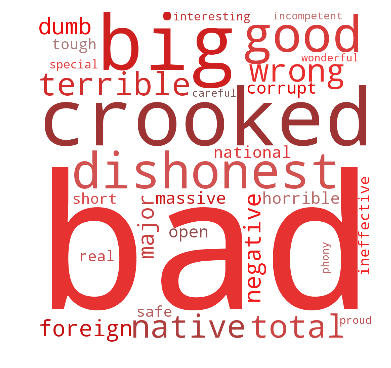

In [114]:
# Plot the wordclouds.
from PIL import Image
from wordcloud import WordCloud
import random

def rep_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (0, random.randint(10, 100), random.randint(40, 60))

def dem_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (224, random.randint(40, 100), random.randint(40, 60))

pfont = {'fontname': 'Palatino Linotype'}
fig, ax = plt.subplots(1, figsize=(6,6))

# masks taken from here:
# https://image.freepik.com/free-icon/elephant-republican-symbol_318-64492.jpg
# https://www.carstickers.com/prodimages/12960-democrat-donkey-sticker.png
republican_mask = np.array(Image.open(root_dir+'/figs/republican-symbol.jpg'))

wcloud_trump = WordCloud(background_color="white",
                         max_words=30,
                         width=1000, height=1000)
wcloud_trump.generate(women_emo_wordcloud)
wcloud_trump.recolor(random_state=5, color_func=rep_color_func)

ax.imshow(wcloud_trump)
ax.axis('off')

fig.savefig(root_dir + '/figs/pyladies_trump_women_sentiment_wordcloud.png', dpi=400)